In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
from scipy.linalg import sqrtm
from torchsummary import summary
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from h5py import File as HDF5File
%matplotlib inline
import torch.nn as nn
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import tensorflow as tf
from scipy.stats import norm
from scipy.stats import gaussian_kde

2025-07-07 11:03:56.011222: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 11:03:56.051701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-07 11:03:56.051736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-07 11:03:56.052679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 11:03:56.058821: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
def plot_generated_samples(generator, kdes, batch_size=16, latent_dim=625):
    generator.eval()  # Set to eval mode to disable dropout/batchnorm updates

    # Latent vectors
    z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat = torch.cat([z_codings, z_noise], dim=1)
    z_feat = z_codings

    with torch.no_grad():
        gen_samples = generator(z_feat)

    gen_samples = gen_samples.cpu()
    
    print("Sample feature coding:", z_codings[1].cpu().numpy())

    fig, axes = plt.subplots(1, min(batch_size, 16), figsize=(min(batch_size, 16), 1))
    for i in range(min(batch_size, 16)):
        axes[i].imshow(gen_samples[i, 0].numpy(), cmap= 'viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    generator.train()  # Restore training mode


def plot_metrics(g_losses, d_losses):
    epochs = range(1, len(g_losses) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, g_losses, label='Generator Loss', color='blue')
    plt.plot(epochs, d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(dataset):
    # Stack all features
    all_features = torch.stack([dataset[i][1] for i in range(len(dataset))])
    
    feature_labels = [
        r"$\eta$", r"Mass", r"$p_T$", r"$\Delta R$",
        r"$\langle \Delta R \rangle$", r"$\sigma_{\Delta R}$",
        r"$\langle Pixel \rangle$", r"$\sigma_{Pixel}$"
    ]
    
    num_features = all_features.shape[1]
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    axs = axs.flatten()
    
    for i in range(num_features):
        axs[i].hist(all_features[:, i+1].cpu().numpy(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axs[i].set_title(f"Feature {i}: {feature_labels[i]}")
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.suptitle("Distributions of Input Features", fontsize=16, y=1.03)
    plt.show()

In [11]:
## Helper Functions for kde distributions, noise, loss, etc

def feature_distributions(dataset):
    all_features = torch.stack([dataset[i][1] for i in range(len(dataset))])
    
    feature_labels = [
        r"$\eta$", r"Mass", r"$p_T$", r"$\Delta R$",
        r"$\langle \Delta R \rangle$", r"$\sigma_{\Delta R}$",
        r"$\langle \mathrm{Pixel} \rangle$", r"$\sigma_{\mathrm{Pixel}}$"
    ]
    
    num_features = all_features.shape[1]
    fig, axs = plt.subplots(3, 3, figsize=(16, 10))
    axs = axs.flatten()

    kde_fits = {}
    
    for i in range(num_features-1):
        data = all_features[:, i+1].cpu().numpy()
        mean_val = data.mean()
        std_val = data.std()

        # Histogram
        counts, bins, _ = axs[i].hist(data, bins=50, alpha=0.4, color='skyblue', edgecolor='black', density=True)

        # KDE fit
        kde = gaussian_kde(data)
        kde_fits[feature_labels[i]] = kde
        x_vals = np.linspace(bins[0], bins[-1], 500)
        axs[i].plot(x_vals, kde(x_vals), label='KDE', color='green')
        axs[i].set_title(feature_labels[i], fontsize=12)
        axs[i].set_xlabel(feature_labels[i])
        axs[i].set_ylabel("Density")
        axs[i].grid(True)
        axs[i].legend()

    plt.tight_layout()
    plt.suptitle("Feature Distributions with Gaussian and KDE Fits", fontsize=16, y=1.03)
    plt.show()
    return kde_fits

def sample_fit_noise(kde_fits, num_samples=1):
    
    feature_labels = [
        r"$\eta$", r"Mass", r"$p_T$", r"$\Delta R$",
        r"$\langle \Delta R \rangle$", r"$\sigma_{\Delta R}$",
        r"$\langle \mathrm{Pixel} \rangle$", r"$\sigma_{\mathrm{Pixel}}$"
    ]

    samples = []
    for label in feature_labels:
        kde = kde_fits[label]
        sampled = kde.resample(num_samples).T.squeeze()
        samples.append(sampled)

    stacked = np.stack(samples, axis=1)  # shape (num_samples, 9)
    return torch.tensor(stacked, dtype=torch.float32)

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach

    def forward(self, x):
        if self.training and self.sigma > 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = torch.randn_like(x) * scale
            return x + sampled_noise
        return x

def kde_kl_divergence_torch(real, fake, bandwidth=0.1, num_points=1000, eps=1e-8):
    min_val = torch.min(real.min(), fake.min()).detach()
    max_val = torch.max(real.max(), fake.max()).detach()
    support = torch.linspace(min_val, max_val, num_points, device=real.device).view(1, -1)  # [1, num_points]

    def kde(samples):
        # [B, 1] - expand to [B, num_points] for distance to each x
        samples = samples.view(-1, 1)
        dists = (samples - support) ** 2  # [B, num_points]
        kernels = torch.exp(-0.5 * dists / bandwidth**2)
        pdf = kernels.sum(dim=0)  # sum over samples -> [num_points]
        pdf /= (pdf.sum() + eps)  # normalize
        return pdf + eps  # avoid log(0)

    p = kde(real)
    q = kde(fake)

    kl = (p * (p.log() - q.log())).sum()
    return kl
    
def MaxReLU(x):
    return torch.minimum(x, torch.tensor(1))

def soft_count_nonzero(x, threshold=3e-3, sharpness=1000.0):
    """
    Soft count of non-zero pixels using a sigmoid approximation.

    Args:
        x (Tensor): shape [batch, 1, H, W]
        threshold (float): value below which pixels are 'effectively zero'
        sharpness (float): controls the steepness of the sigmoid

    Returns:
        Tensor: soft non-zero pixel counts, shape [batch]
    """
    return torch.sigmoid(sharpness * (x - threshold)).sum(dim=(1, 2, 3))

In [5]:
class JetDataset(Dataset):
    def __init__(self, data, n_events):
        self.images = torch.tensor(data['image'][:n_events], dtype=torch.float32)
        self.flipped_images = torch.flip(self.images,[1])

        # Normalize
        self.images = (self.images - self.images.min()) / (self.images.max() - self.images.min())
        self.flipped_images = (self.flipped_images - self.flipped_images.min()) / (self.flipped_images.max() - self.flipped_images.min())

        # ----- ΔR Calculation -----
        print(f"Image shape: {self.images.shape}")
        H, W = self.images[0].shape
        center_x, center_y = (W - 1) / 2, (H - 1) / 2  # center = (12, 12)

        # Coordinate grid
        x_coords, y_coords = torch.meshgrid(
            torch.arange(W, dtype=torch.float32),
            torch.arange(H, dtype=torch.float32),
            indexing='ij'
        )

        # Distance from center
        dists = torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)

        # Weighted: sum(pixel * distance) / sum(pixel)
        weights = self.images
        weight_norm = self.images.max()

        dR = (weights * dists) / weight_norm

        # dim = (1,2,3)
        dR_mean = dR.mean(dim = (1,2))
        dR_std = dR.std(dim = (1,2))
        print(f"dR Mean: {dR_mean.shape}")
        print(f"dR STD: {dR_std.shape}")
        
        # Pixel stats
        pixel_mean = weights.mean(dim = (1,2))
        pixel_std = weights.std(dim = (1,2))
        print(f"Pixel Mean: {pixel_mean.shape}")
        print(f"Pixel STD: {pixel_std.shape}")

        self.features = torch.tensor(np.stack([
            data['signal'][:n_events],
            data['jet_eta'][:n_events],
            data['jet_pt'][:n_events],
            data['jet_mass'][:n_events],
            data['jet_delta_R'][:n_events],
            dR_mean, 
            dR_std, 
            pixel_mean, 
            pixel_std
        ], axis=1), dtype=torch.float32)
        
        self.flipped_features = torch.tensor(np.stack([
            data['signal'][:n_events],
            -data['jet_eta'][:n_events],
            data['jet_pt'][:n_events],
            data['jet_mass'][:n_events],
            data['jet_delta_R'][:n_events],
            dR_mean, 
            dR_std, 
            pixel_mean, 
            pixel_std,
        ], axis=1), dtype=torch.float32)

        # Normalize just pt and mass features here also
        # Normalize jet_mass (index 2)
        self.features[:, 2] = (self.features[:, 2]-self.features[:, 2].min()) / (self.features[:, 2].abs().max()-self.features[:, 2].min())
        
        # Normalize jet_pt (index 3)
        self.features[:, 3] = (self.features[:, 3]-self.features[:, 3].min()) / (self.features[:, 3].abs().max()-self.features[:, 3].min())
        
        # Same for flipped features
        self.flipped_features[:, 2] = (self.flipped_features[:, 2]-self.flipped_features[:, 2].min()) / (self.flipped_features[:, 2].max()-self.flipped_features[:, 2].min())
        self.flipped_features[:, 3] = (self.flipped_features[:, 3]-self.flipped_features[:, 3].min()) / (self.flipped_features[:, 3].max()-self.flipped_features[:, 3].min())

        print("ΔR min:", dR.min().item())
        print("ΔR max:", dR.max().item())
        
        print("ΔR mean min:", dR_mean.min().item())
        print("ΔR mean max:", dR_mean.max().item())
        
        print("ΔR std min:", dR_std.min().item())
        print("ΔR std max:", dR_std.max().item())
        
        print("Weights (pixel intensity) min:", weights.min().item())
        print("Weights (pixel intensity) max:", weights.max().item())
        
        print("Pixel mean min:", pixel_mean.min().item())
        print("Pixel mean max:", pixel_mean.max().item())
        
        print("Pixel std min:", pixel_std.min().item())
        print("Pixel std max:", pixel_std.max().item())

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        image = self.images[idx]
        flipped_image = self.flipped_images[idx]
        features = self.features[idx]
        flipped_features = self.flipped_features[idx]

        return image, features, flipped_image, flipped_features

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=25*25):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.2)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 25*25),
            nn.LayerNorm(25*25),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(25*25, 256, kernel_size=4, stride=1, padding=0),
            # nn.BatchNorm2d(256),
            nn.LayerNorm([256, 4, 4]),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            nn.LayerNorm([128, 8, 8]),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(64),
            nn.LayerNorm([64, 16, 16]),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.LayerNorm([32, 16, 16]),
            nn.ReLU(),
        )
        self.image_gen5 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, padding=0),
            # nn.BatchNorm2d(16),
            nn.LayerNorm([16, 20, 20]),
            nn.ReLU(True),
        )
        
        self.image_gen6 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=1, padding=0),
            nn.LayerNorm([1, 25, 25]),
            nn.ReLU(True),
        )

        self.image_gen = nn.Sequential(
            # 1x1 → 4x4
            nn.ConvTranspose2d(25*25, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # 4x4 → 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # 8x8 → 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),

            # 16x16 → 25x25
            nn.ConvTranspose2d(64, 1, kernel_size=10, stride=1, padding=0),
            # nn.Sigmoid()
            nn.ReLU(True)
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        img = img.view(-1, 625, 1, 1)
        img = self.image_gen(img)
        
        # img = self.image_gen1(img)
        # # print(img.shape)
        # img = self.image_gen2(img)
        # # print(img.shape)
        # img = self.image_gen3(img)
        # # print(img.shape) 
        # img = self.image_gen4(img)
        # # print(img.shape)
        # img = self.image_gen5(img)
        # # print(img.shape)
        # img = self.image_gen6(img)
        # # print(img.shape)
        img = MaxReLU(img)
        
        # threshold = 0.001
        # img = torch.where(img < threshold, torch.tensor(0.0, device=img.device), img)

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 25*25 = 625
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 25, 25)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([43633, 25, 25])
dR Mean: torch.Size([43633])
dR STD: torch.Size([43633])
Pixel Mean: torch.Size([43633])
Pixel STD: torch.Size([43633])
ΔR min: 0.0
ΔR max: 2.8717432022094727
ΔR mean min: 0.00102589325979352
ΔR mean max: 0.007139019668102264
ΔR std min: 0.007089022547006607
ΔR std max: 0.11601806432008743
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0014341502683237195
Pixel mean max: 0.0018129752716049552
Pixel std min: 0.006397501099854708
Pixel std max: 0.04007731005549431


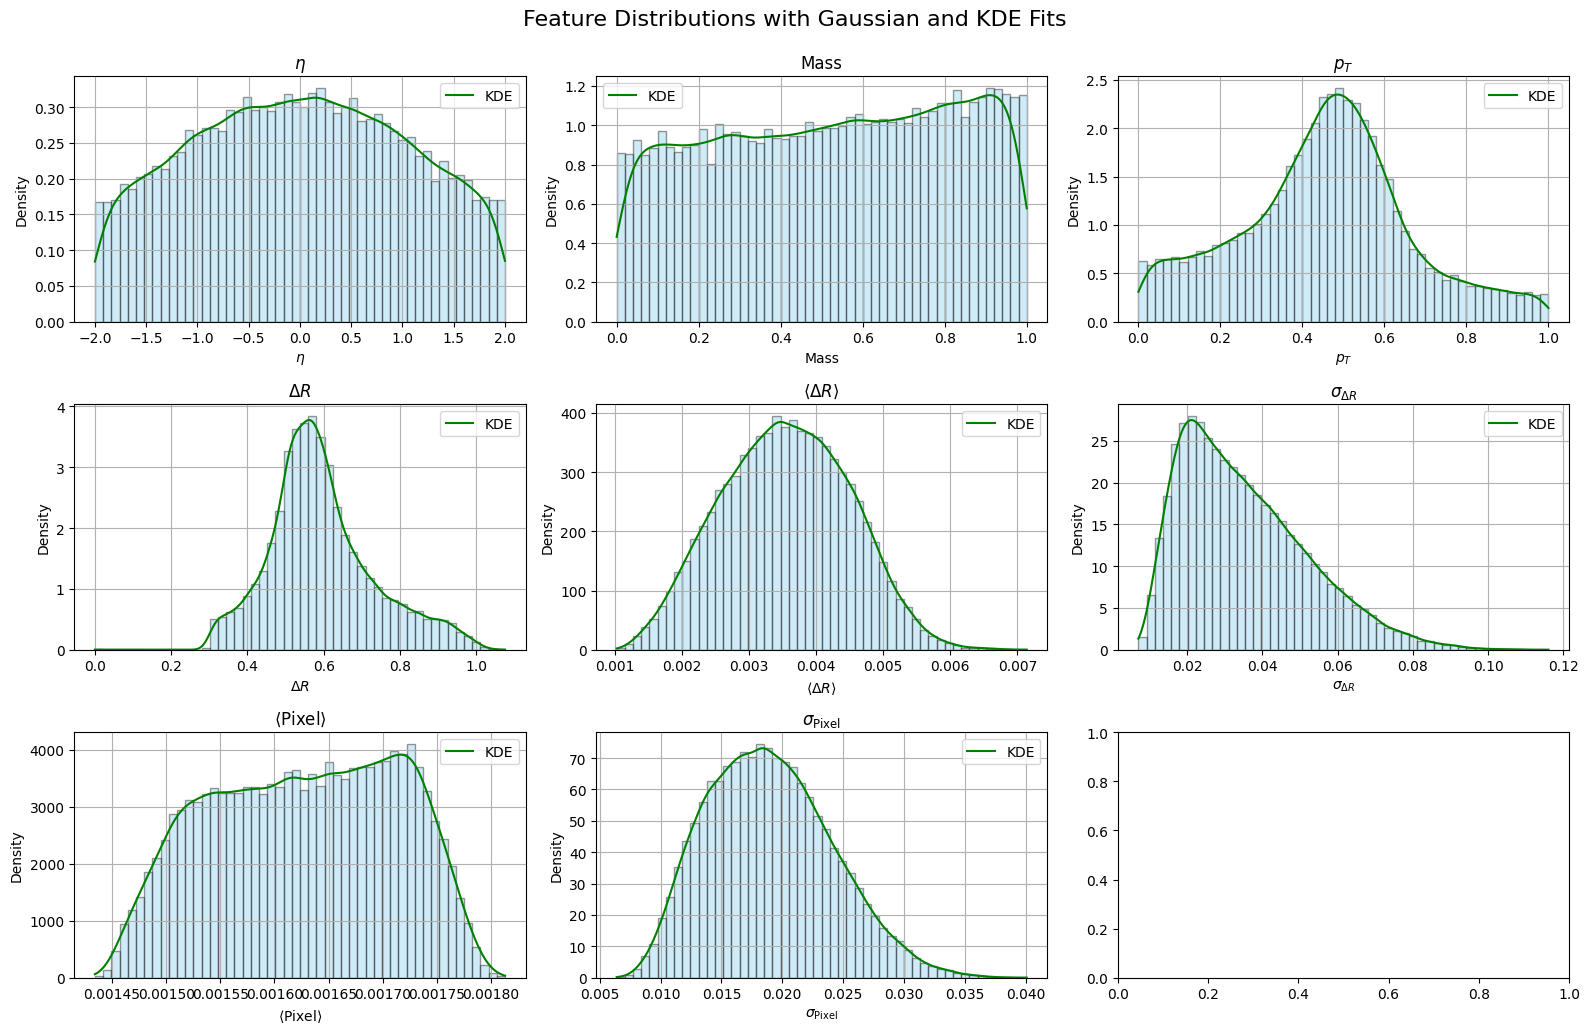

Number of samples: 43633
Image shape: torch.Size([43633, 25, 25])
Feature shape: torch.Size([43633, 9])


In [18]:
batch_size = 128
n_events = int(.05 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

[Epoch 1/30] [D loss: 0.0066] [G loss: 0.3779] [Validity_loss: 0.3430] [Stat_loss: 0.0339] [NNZ_loss: 0.0009]
Sample feature coding: [1.         1.48157    0.83150023 0.57515985 0.84674144 0.00257592
 0.02678646 0.00157973 0.02563026]


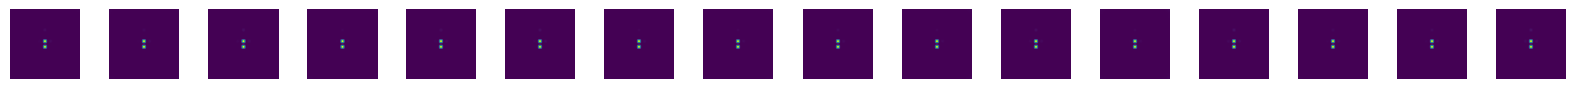

[Epoch 2/30] [D loss: 0.6872] [G loss: 0.0491] [Validity_loss: 0.0451] [Stat_loss: 0.0035] [NNZ_loss: 0.0005]
Sample feature coding: [ 1.         -0.14396234  0.7826716   0.5960232   0.64414734  0.00167492
  0.04468999  0.00174481  0.0222532 ]


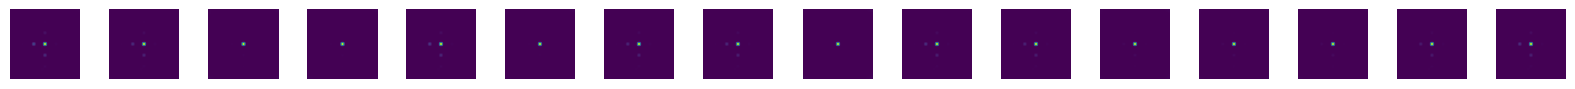

[Epoch 3/30] [D loss: 0.0337] [G loss: 0.3563] [Validity_loss: 0.3112] [Stat_loss: 0.0444] [NNZ_loss: 0.0006]
Sample feature coding: [ 0.         -0.28361928  0.25521418  0.18406105  0.5912791   0.00466261
  0.01837842  0.00148152  0.01531022]


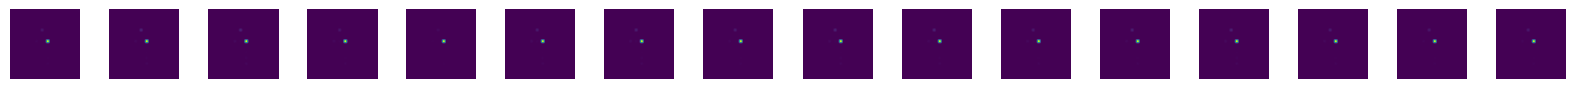

[Epoch 4/30] [D loss: 0.1776] [G loss: 0.3210] [Validity_loss: 0.2636] [Stat_loss: 0.0561] [NNZ_loss: 0.0013]
Sample feature coding: [ 1.         -0.9730575   0.6506602   0.3785173   0.55076385  0.00280889
  0.01209951  0.0016907   0.01630964]


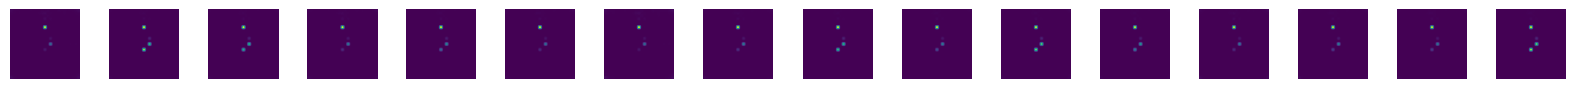

[Epoch 5/30] [D loss: 0.0139] [G loss: 0.3710] [Validity_loss: 0.3689] [Stat_loss: 0.0008] [NNZ_loss: 0.0013]
Sample feature coding: [0.         0.32738882 0.40880573 0.04062546 0.59977233 0.00445372
 0.02067506 0.00175027 0.01860442]


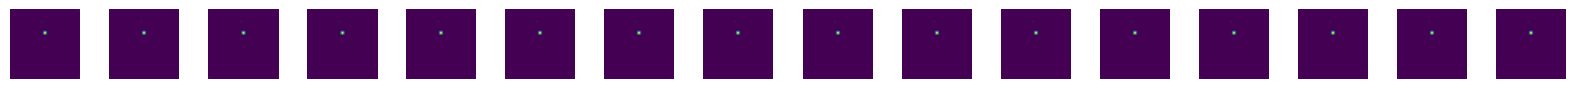

In [ ]:
tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

latent_dim = 25*25
lr = 0.0005
n_epochs = 30

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (25, 25)
H, W = (25,25)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 25, 25]

for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 1 == 0:
            optimizer_D.zero_grad()

            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:4]
            real_flipped_disc_codings = real_flipped_feat[:,:4]
            fake_disc_codings = z_codings[:,:4]
            fake_flipped_disc_codings = flipped_z_codings[:,:4]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()

            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:4]
            real_flipped_disc_codings = real_flipped_feat[:,:4]
            fake_disc_codings = z_codings[:,:4]
            fake_flipped_disc_codings = flipped_z_codings[:,:4]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = fake_img.squeeze(1).mean(dim = (1,2))
            fake_pixel_std = fake_img.squeeze(1).std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = fake_flipped_img.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = fake_flipped_img.squeeze(1).std(dim = (1,2))


            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]

            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean)
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std)
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean)
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std)

            stat_loss = kl_total


            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=1000.0) / (25 * 25)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=1000.0) / (25 * 25)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .03
            beta = 3
            chi = 10

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,3:6].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6:9].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,9:12].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,12:15].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 25*25, 1, 1).cuda() 

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, kdes, batch_size=16, latent_dim=625)


plot_metrics(g_losses, d_losses)

# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):  # for each statistic
    ax = axs[row]

    real_vals = real_stats[row][:]
    fake_vals = fake_stats[row][:]

    ax.hist(real_vals, bins=200, alpha=0.6, label='Real', edgecolor='black')
    ax.hist(fake_vals, bins=200, alpha=0.6, label='Fake', edgecolor='black')
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()

In [ ]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = jet_mass_data['image'][:n_images].min()
vmax = jet_mass_data['image'][:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(jet_mass_data['image'][i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
def test_generated_samples(generator, kdes, batch_size=4, latent_dim=625, codings = None):
    generator.eval()  # Disable dropout/batchnorm updates

    if codings == None:
        # Latent vectors and codings
        z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
        z_codings = torch.cat([
            torch.randint(0, 2, (batch_size, 1)), 
            sample_fit_noise(kdes, num_samples=batch_size)
        ], dim=1).cuda()
    
        with torch.no_grad():
            gen_samples = generator(z_codings).cpu()  # Shape: (B, 3, 25, 25)
    
        print("Generated sample shape:", gen_samples.shape)
        print("Sample feature codings:", np.round(z_codings[:].cpu().numpy(), 4))

    else:
        z_codings = torch.cat(torch.tensor(batch_size), torch.tensor(codings))
        with torch.no_grad():
            gen_samples = generator(z_codings).cpu()  # Shape: (B, 3, 25, 25)
    
        print("Generated sample shape:", gen_samples.shape)
        print("Sample feature codings:", np.round(z_codings[:].cpu().numpy(), 4))

    # Plot: 3 rows (channels) x batch_size columns
    fig, axes = plt.subplots(nrows=3, ncols=batch_size, figsize=(batch_size * 1.5, 4.5))
    channel_titles = ['Layer 1', 'Layer 2', 'Layer 3']

    for b in range(batch_size):
        for c in range(3):
            ax = axes[c, b]
            ax.imshow(gen_samples[b, c].numpy(), cmap='viridis')
            ax.axis('off')
            if b == 0:
                ax.set_ylabel(channel_titles[c], fontsize=10)

    plt.tight_layout()
    plt.suptitle("Generated Jet Images", fontsize=14, y=1.02)
    plt.show()

    generator.train()  # Restore training mode

In [ ]:
test_generated_samples(generator, kdes, batch_size=16, latent_dim=625)